In [34]:
import numpy as np

In [35]:
import control.matlab as ml

In [36]:
import matplotlib.pyplot as plt

# Full Bridge Converter

## 1. Power Stage

Forward, two-switch forward, active-clamp forward and half-bridge converters are also buck-derived topologies, but their input/output voltage transfer functions are multiplied by the transformer turns ratio. Push-pull, full bridge and
phase-shifted full bridge also have the same input/output voltage transfer function, but with a factor of 2 multiplier as well as the transformer turns ratio.

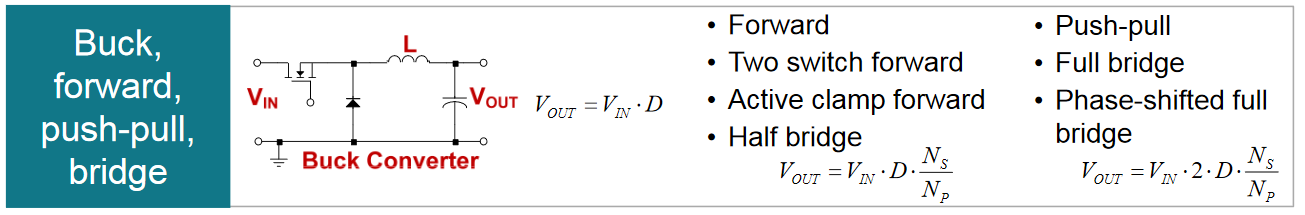

The current-mode buck power stage incorporates the inductor current sense as an inner control loop. The current loop
acts as a lossless damping resistor, splitting the complex conjugate pole of the output filter into two real poles.

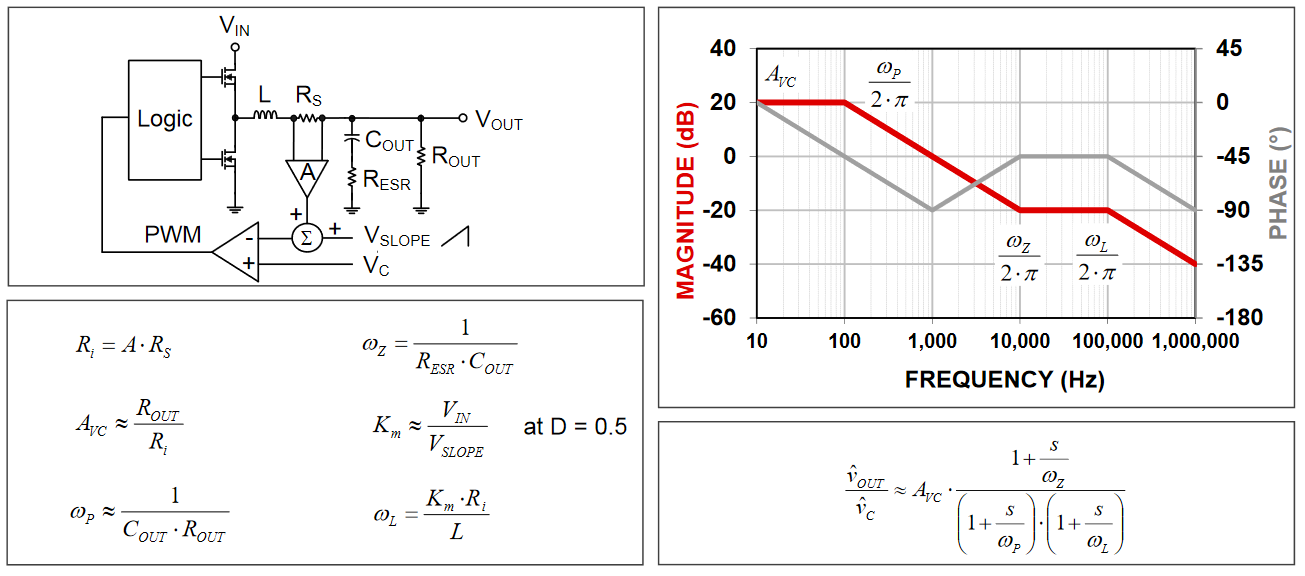

In our design, the sensing resistor Rs is 2.74 Ohm. A is turn's ratio of the current sensing transformer, which is 1:150, so Ri is 2.74/150=0.0183 Ohm. 

In [37]:
Ri=2.74/150
print(Ri)

0.018266666666666667


Slope current is 100uA, slope resistance is Vslope is 499Ohm, so Vslope=0.05V. Vin is 24V.So Km=480.

In [38]:
Islope=100*pow(10,-6)
Rslope=499
Vslope=Islope*Rslope
Vin=24
Km=Vin/Vslope
print(Km)

480.96192384769546


Rout is the load resistor. At full load, it is 48V/8A=6 Ohm. At no load, it is infinity.

In [39]:
Vout=48
Iout=8
Rout=Vout/Iout
print(Rout)

6.0


Inductor L is 22uH.

In [52]:
L=22*pow(10, -6)
print(L)

2.2e-05


Without external capacitors, Cout is 127.6uF. Max 5700 supported DC capacitance is 39000uF, capacitor in each DSx is 5uF, so maximum total capacitance is 127.6uF+39000uF+5uF*32=39287.6uF.

In [41]:
Cout=(220/2+2.2*8+39000+5*32)*pow(10,-6)
print(Cout)

0.0392876


Maximum dissipation factor of the film cap at the output side of the converter is 10% at 1kHz. So its ESR is 2.2*10^-6 * 1000 * 10% * 8=1.76mOhm.

In [42]:
Resr=2.2*pow(10,-6)*1000*0.1*8
print(Resr)

0.0017600000000000003


ESR zero can be calculated to be:

In [43]:
w_z=1/(Resr*Cout)
print(w_z)

14462.115735800053


Low frequency pole can be calculated to be:

In [44]:
w_p=1/(Cout*Rout)
print(w_p)

4.2422206158346825


High frequency pole can be calculated to be:

In [53]:
w_L=Km*Ri/L
print(w_L)

399344.14283111686


Low frequency gain can be calculated to be:

In [54]:
A_vc=Rout/Ri
print(A_vc)

328.4671532846715


The control-to-output transfer function of the power stage tf_p can be calculated as:

In [71]:
num_p=np.array([1/w_z,1])*A_vc  #numerator

In [72]:
den_p=np.polymul(np.array([1/w_p,1]),np.array([1/w_L,1]))  #denominator

In [73]:
tf_p=ml.tf(num,den)
print(tf)


      0.02271 s + 328.5
----------------------------
5.903e-07 s^2 + 0.2357 s + 1



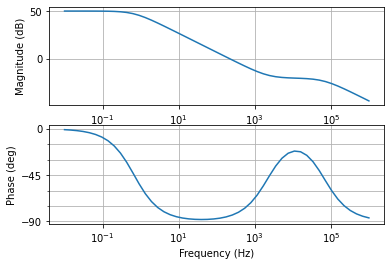

In [79]:
mag_p,phase_p,w_p=ml.bode(tf_p)

## 2. Compensation Stage

### 2.1 Type II Error Amplifier

A type II error amplifier is shown in the following picture. It has 2 poles and 1 zero. Note that this type of compensator alwasy has a net negative phase (The bode plot in the picture has been shifted up by 180 degree. Its real phase is between -90 to 0 degree). For this reason, type II compensators cannot be used for voltage-mode control in CCM where there is a large phase drop just after the resonant frequency. So Type II compensator is usually used for current-mode control compensation, or for converters that always operate in the DCM region.

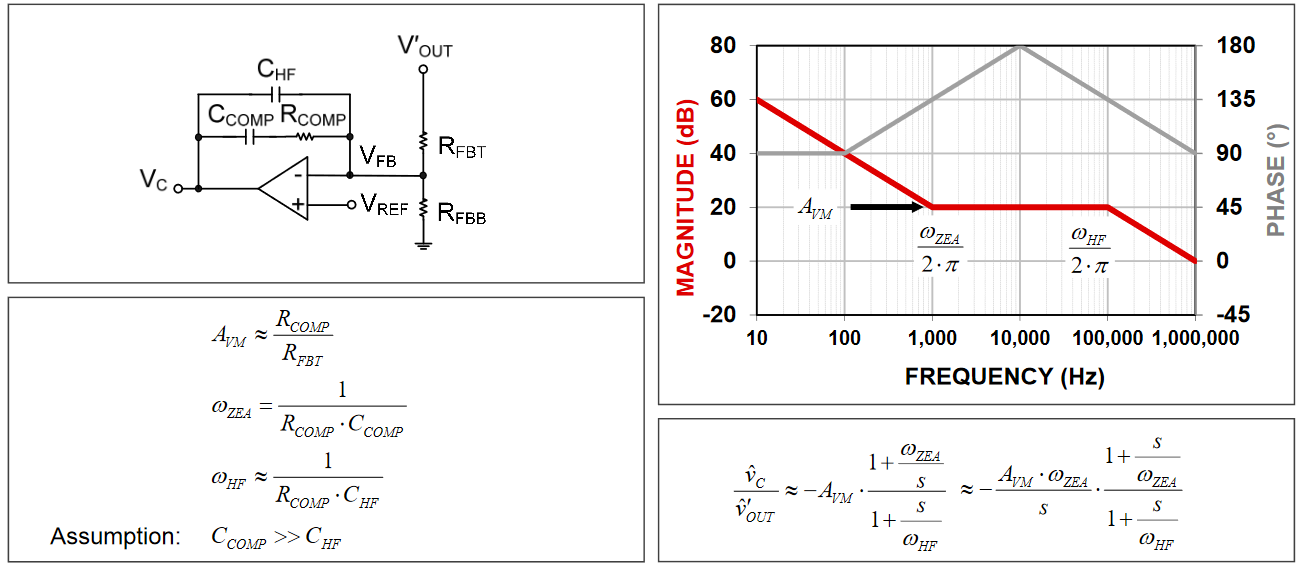

### 2.2 Isolated feedback with optocoupler

In practice, type II compensation is usually implemented using an optocoupler and the TL431 shunt regulator. The current-transfer ratio of the optocoupler and resistors set the mid-band gain. Bias currents and the diode forward voltage limit the dynamic range.

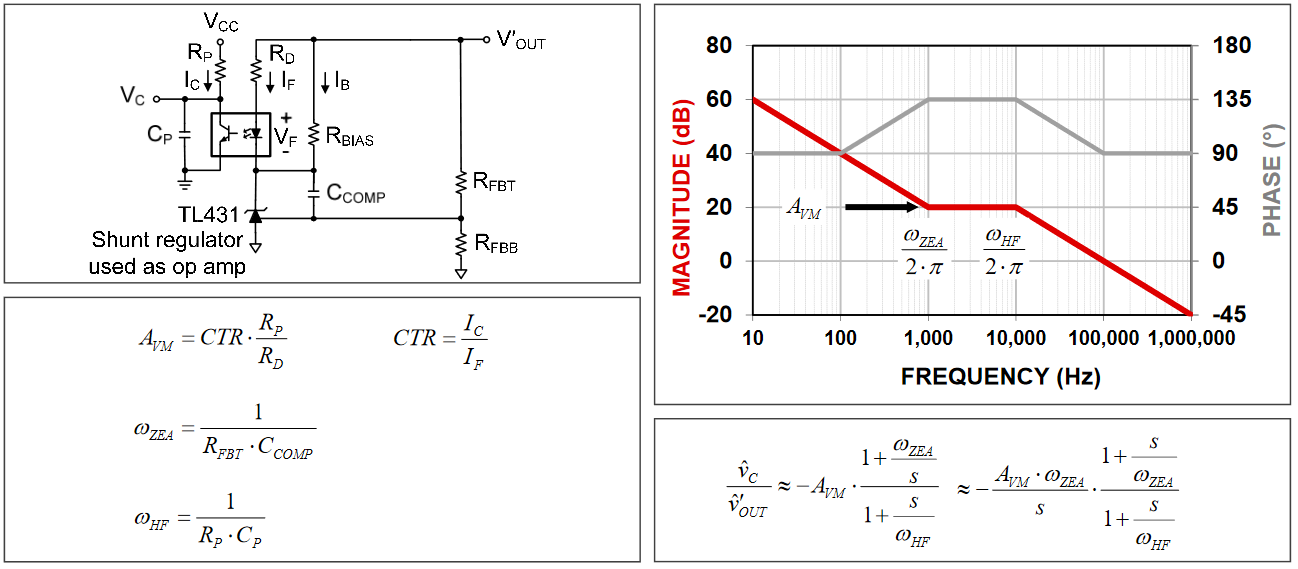

CTR is between 200% and 600%

In [59]:
CTR=4
print(CTR)

4


Rp is 5 kOhm inside the controller LM5045.

In [68]:
R_p=5000
print(R_p)

5000


Rd is equivalent to (R150*R169+R150*R170+R169*R170)/R169, which equals to 3 times 4.7 kOhm.

In [69]:
R_d=4700*3
print(R_d)

14100


R_FBT is a 18.2 kOhm resistor in series with a 20 Ohm resistor.

In [63]:
R_FBT=18200+20
print(R_FBT)

18220


C_comp is selected to be 0.047uF

In [62]:
C_comp=0.047*pow(10,-6)
print(C_comp)

4.7e-08


Cp is parasitic collectr-emitter capacitance of the optocoupler, which is 10pF at 1MHz according to TOSHIBA TLP385's datasheet.

In [67]:
C_p=10*pow(10,-12)
print(C_p)

1e-11


In [70]:
A_vm=CTR*R_p/R_d
w_ZEA=1/(R_FBT*C_comp)
w_HF=1/(R_p*C_p)
print(A_vm,w_ZEA,w_HF)

1.4184397163120568 1167.7604689726045 20000000.0


The transfer function of the compensator stage can be calculated as:

In [77]:
num_c=np.array([1/w_ZEA,1])*A_vm*w_ZEA  #numerator
den_c=np.polymul(np.array([1,0]),np.array([1/w_HF,1]))  #denominator
tf_c=ml.tf(num_c,den_c)
print(tf_c)


1.418 s + 1656
--------------
5e-08 s^2 + s



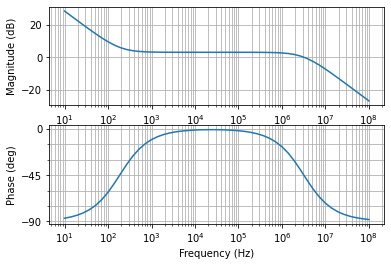

In [80]:
mag_c,phase_c,w_c=ml.bode(tf_c)

The close-loop bode plot is:

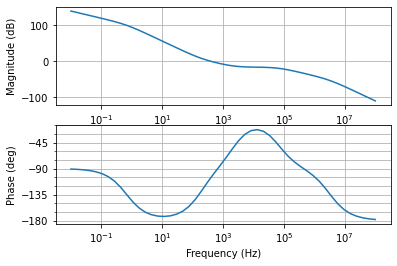

In [81]:
mag,phase,w=ml.bode(tf_p*tf_c)